# AdPMCMC on model $M_0$

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import scipy
from scipy.stats import invgamma
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We begin by considering the model $M_0$ : 
\begin{equation}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_0 \sim \mathcal{N}(0, 1)$.
We use inverse Gamma priors for the variance noises :

$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$

$\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$

with hyperpameters $\alpha_\epsilon=\alpha_w=T/2$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

For synthetic data simulation, the authors set :

In [13]:
# model parameters
b_0 = 0.15 
theta = 0.1
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 50 # time horizon

# inverse gamma prior hyperparameters
alpha_eps = alpha_w =  T/2 
beta_eps = beta_w = 2*(alpha_eps -1)/10

In [14]:
def trajectorySimulationM0(T):
    """
    Simulates latent variable and observation trajectories of horizon T for the M_0 model
    """
    
    # Initialization of latent variable trajectory
    log_N = np.zeros(T+1)
    
    # Arbitrary initialization (found in the paper p. 12)
    log_N[0] = np.log(n_0)
    
    # Latent variable simulation
    for t in range(T):
        log_N[t+1] = log_N[t] + b_0 + np.random.normal(0, sigma_eps**2)
    
    # Observation variable
    Y = np.exp(log_N) + np.random.normal(0, sigma_w**2, T+1)
    
    return log_N, Y

Problem : $g_t$ from the observation process is not defined in the paper.

Since, in the paper, $p(y_t | n_t, \sigma^2_w)$ is assumed to be the density of a Gaussian distribution with mean $n_t$ and variance $\sigma^2_w$, I assume $g_t$ is the identity function.

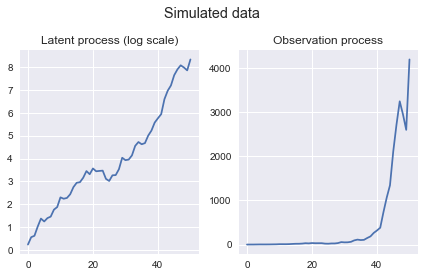

In [15]:
# Simulate and plot a trajectory
log_N, Y = trajectorySimulationM0(T)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data", fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

## MCMC proposal for $\theta$

TODO : 
- define adaptive theta proposal

In [5]:
# non-adaptive theta proposal
def nonAdaptiveThetaProposal(theta):
    """ 
    Non-adaptive Gaussian kernel for parameter proposal
    """
    d = theta.shape[0]
    return np.random.multivariate_normal(theta, (0.1)**2/d * np.eye(d))

In [6]:
# adaptive theta proposal
def adaptiveThetaProposal(theta):
    """ 
    Adaptive Gaussian kernel for parameter proposal
    See algorithm 2 of paper
    """
    return 0

## SMC sampler for $n_{1:T}$

In [7]:
# Random initialization
sigma_eps = invgamma.rvs(a=alpha_eps, scale=beta_eps)
sigma_w = invgamma.rvs(a=alpha_w, scale=beta_w)
sigma_eps, sigma_w

(0.19775852559517773, 0.23624593146788364)

In [8]:
def g(y, log_n, sigma_w):
    """
    Observation process
    """
    return scipy.stats.norm.pdf(y, np.exp(log_n), sigma_w)

def stratifiedResampling(weights):
    """
    Stratified resampling
    Returns drawn indexes as a list
    weights needs to be a numpy array
    """
    n_samples = weights.shape[0]
        
    # Generate n_samples sorted uniforms with stratified sampling
    sorted_uniforms = np.zeros(n_samples)
    for n in range(n_samples):
        sorted_uniforms[n] = np.random.uniform(n/n_samples, (n+1)/n_samples)
        
    sampled_indexes = []
    j, partial_sum_weights = 0, weights[0]
    for n in range(n_samples):
        while sorted_uniforms[n] > partial_sum_weights:
            j += 1
            partial_sum_weights += weights[j]
        sampled_indexes += [j]
        
    return sampled_indexes

def q(theta, theta_prev):
    return scipy.stats.multivariate_normal.pdf(theta, theta_prev, (0.1)**2/d * np.eye(d))

In the paper, there seems to be a simulation of $b_0$ per particles, see Algorithm 1, p.31 

See "Log-PF: Particle Filtering in Logarithm Domain" for log-normalization of weights

In [9]:
# n | theta proposal
def SMC(y, T, L, n_0, b_0, sigma_eps, sigma_w):
    """
    Particle filter 
    """
    
    # L is the number of particles
    log_particles = np.zeros((T, L))
    
    # Weights matrix
    W = np.zeros((T, L))
    
    # Log-weights matrix
    log_W = np.zeros((T, L))
    
    # Initial propagation
    log_particles[0, :] = np.log(n_0) + b_0 + np.random.normal(0, sigma_eps, L)
        
    # Not sure about W initialization
    for l in range(L):
        log_W[0, l] = np.log(g(y[0], log_particles[0, l], sigma_w))
    
    # Weight normalization (log scale)
    log_W[0, :] -= np.max(log_W[0, :]) # scaling   
    log_sum_of_weights = np.log(sum(np.exp(log_W[0, :]))) 
    log_W[0, :] -= log_sum_of_weights
    
    W[0, :] = np.exp(W[0, :])
    
    for t in range(1, T):
        for l in range(L):
            # Propagation
            log_particles[t, l] = log_particles[t-1, l] + b_0 + np.random.normal(0, sigma_eps)
            
            # Weight computation
            log_W[t, l] = log_W[t-1, l] + np.log(g(y[t], log_particles[t, l], sigma_w))
        
        # Weight normalization (log scale)
        log_W[t, :] -= np.max(log_W[t, :]) # scaling   
        log_sum_of_weights = np.log(sum(np.exp(log_W[t, :]))) 
        log_W[t, :] -= log_sum_of_weights
                
        # Adaptive resampling : sample if ESS < 80% of number of particles
        ESS = 1/sum(np.exp(W[t, :])**2)
                
        if ESS < 0.8*L:
            # resample indexes according to the normalized importance weights
            resampled_indexes = stratifiedResampling(np.exp(log_W[t, :])) 
            log_particles[t, :] = log_particles[t, resampled_indexes]
            log_W[t, :] = np.log(np.ones(L)/L) # the new particles have equal weight
        
        W[t, :] = np.exp(log_W[t, :])
        
    # Evaluate marginal likelihood
    marginal_likelihood = np.prod(np.sum(W, axis=1)/L)
    
    return log_particles, W, marginal_likelihood

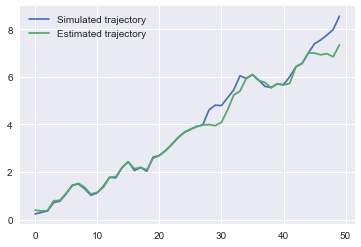

In [10]:
L = 50

log_particles, W, marginal_likelihood = SMC(Y, T, L, n_0, b_0, sigma_eps, sigma_w)

log_particles_averaged = [np.average(log_particles[t,:], weights=W[t,:], axis=0) for t in range(T)]

plt.plot(log_N[:-1])
plt.plot(log_particles_averaged) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])

## Stage 3 : Generic PMCMC

TODO (everything is described page 9): 
- define initialization of generic PMCMC
- compute acceptance proba (what is $p(\theta)$ ?)
- sample candidate path

In [12]:
n_steps = 10

# draw uniforms for accept-reject procedure
uniforms = np.random.uniform(0, 1, n_steps)

theta_hist = []
N_hist = []

# Initialization ??

theta = np.array([b_0, sigma_eps, sigma_w])

for j in range(n_steps):
    # draw theta wrt non adaptive proposal
    theta = nonAdaptiveThetaProposal(theta)
    b_0, sigma_eps, sigma_w = theta 
    
    # run SMC
    log_particles, W, marginal_likelihood = SMC(Y, T, L, n_0, b_0, sigma_eps, sigma_w)
    
    # sample a candidate path
    # needs to be randomized
    candidate_path = log_particles[:, 1]
    
    # compute acceptance proba
    marginal_likelihood_ratio = marginal_likelihood/prev_marginal_likelihood
    marginal_theta_ratio = 1 # to compute
    theta_proposal_ratio = q(theta, theta_hist[-1])/q(theta_hist[-1], theta)
    
    alpha = marginal_likelihood_ratio*marginal_theta_ratio*theta_proposal_ratio
    
    if uniforms[j] < alpha:
        prev_marginal_likelihood = marginal_likelihood
        theta_hist.append(theta)
        N_hist.append(candidate_path)

NameError: name 'prev_marginal_likelihood' is not defined

## Annealing

Random initialization of the parameters $(\theta, N_{1:T})$, followed by annealed AdPMCMC using a sequence of distribuitons :

\begin{equation}
p_n(\theta, N_{1:T} | y_{1:T}) = p(\theta, N_{1:T})^{1-\gamma_n}p(y_{1:T}|\theta, N_{1:T})^{\gamma_n}
\end{equation}

(in the model $M_0$, $\theta = (b_0, \sigma_\epsilon, \sigma_w)$